In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import requests as re
import osmnx as ox
import networkx as nx
import h3
import os
import ast
import tqdm
import shapely as shp
import time
import json
import folium

from shapely.ops import unary_union, transform
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

file_path = '../config/API_KEY.json'
with open(file=file_path,mode= 'r') as f:
    json_data = json.load(f)
API_KEY = json_data['apiKey']

In [3]:
place_name = "Haarlem, Netherlands"
# Get the boundary of the place
gdf = ox.geocode_to_gdf(place_name)
# Get the boundary polygon
haarlem_boundary = gdf.geometry.values[0]

centroid_haarlem = haarlem_boundary.centroid
map_ = folium.Map(location=[centroid_haarlem.y, centroid_haarlem.x],
                 zoom_start=13)
# Add the boundary to the map
folium.GeoJson(
    haarlem_boundary.__geo_interface__,
    style_function=lambda x: {'color': 'blue',
                            'weight': 2,
                            'fillOpacity': 0.1}
).add_to(map_)
map_

In [4]:
# flip coordinate sequence from longitude, latitude to latitude, longitude as this is how the h3 API reads it
def flip(x,y):
    return y,x
haarlem_boundary = transform(flip,haarlem_boundary)
# Convert to plan geojson object
haarlem_boundary_geojson = gpd.GeoSeries([haarlem_boundary])\
    .__geo_interface__['features'][0]['geometry']

# Get h3 cell IDs for cells within the bounding polygon / geojson
res8_haarlem_hex = h3.polyfill(haarlem_boundary_geojson,8)

def func_visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    original source: https://nbviewer.org/github/uber/h3-py-notebooks/blob/master/notebooks/usage.ipynb

    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # Flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium\
            .Map(location=[sum(lat)/len(lat),
                        sum(lng)/len(lng)],
                        zoom_start=12, 
                        tiles='openstreetmap')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=2,color=color)
        m.add_child(my_PolyLine)
    return m

map_ = func_visualize_hexagons(hexagons=res8_haarlem_hex)
map_

In [5]:
res9_haarlem_hex = h3.polyfill(haarlem_boundary_geojson,9)
res10_haarlem_hex = h3.polyfill(haarlem_boundary_geojson,10)

res8_haarlem_hex = pd.DataFrame({'hex_id':list(res8_haarlem_hex),
                                 'hex_resolution':8})
res9_haarlem_hex = pd.DataFrame({'hex_id':list(res9_haarlem_hex),
                                 'hex_resolution':9})
res10_haarlem_hex = pd.DataFrame({'hex_id':list(res10_haarlem_hex),
                                  'hex_resolution':10})
# Concatenate the three dataframes
haarlem_hex_df = pd.concat([res8_haarlem_hex,
                            res9_haarlem_hex,
                            res10_haarlem_hex],
                            ignore_index=True)

# Function to calculate the radius of a hexagon based on
# it's resolution and a buffer value to be safe
def func_get_hex_radius(row,BUFFER):
    edge_length = h3.edge_length(row.hex_resolution,'m')
    radius = edge_length
    radius = radius+edge_length*BUFFER
    return radius

haarlem_hex_df['hex_area'] = haarlem_hex_df\
    .hex_id\
    .apply(lambda x: h3.cell_area(x,unit='m^2'))
haarlem_hex_df['hex_radius_places_api'] = haarlem_hex_df\
    .apply(lambda row: func_get_hex_radius(row,0.15),axis=1)
haarlem_hex_df['centroid'] = haarlem_hex_df\
    .hex_id\
    .apply(lambda x: h3.h3_to_geo(x))

In [6]:
def func_get_places_poi(lat,lng,resolution,type,api_key):
    
    # Nearby sarch API URL
    url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    params = {
    'location': f'{lat},{lng}',
    'radius': resolution,
    'types': type,
    'key': api_key}

    response = re.get(url, params=params)
    places_df = []

    results = json.loads(response.content)

    places_df.append(results['results'])

    while 'next_page_token' in results:
        time.sleep(1)
        params['pagetoken'] = results['next_page_token']
        response = re.get(url,params=params)
        results = json.loads(response.content)
        places_df.append(results['results'])
        
    results_df = pd.concat([pd.DataFrame(df) for df in places_df])
    results_df = results_df.reset_index(drop=True)
    
    return results_df

In [ ]:
max_haarlem_hex_def = haarlem_hex_df[haarlem_hex_df.hex_resolution==haarlem_hex_df.hex_resolution.min()]

# All types of POI we want to search for
ALL_TYPES = ['tourist_attraction','cafe','museum','art_gallery','park','restaurant','zoo',
             'art_gallery','theme_park', 'library','church','shopping_mall']

for type in ALL_TYPES:
    # Create a directory for each type if it doesn't exist
    if not os.path.exists(f'../data/h3cell_output_{type}/'):
        os.makedirs(f'../data/h3cell_output_{type}/')

    print(type)

    searched_cells = os.listdir(f'../data/h3cell_output_{type}/')
    # If the directory is empty, we can start from scratch
    if(len(searched_cells)>0):
        searched_cells = set([x.replace('.csv','') for x in searched_cells])

    # Loop through the hexagons and get the POI data
    for ind,row in tqdm.tqdm(max_haarlem_hex_def.iterrows(),
                            total=max_haarlem_hex_def.shape[0]):
        
        # Parsing the highest resolution cells and saving outputs in a csv file
        h3_cell = row.hex_id
        if(h3_cell not in searched_cells):
            lat,lng = row.centroid[0],row.centroid[1]
            resolution = row.hex_radius_places_api
            # Call the Places API wrapper using the the function we wrote earlier
            df = func_get_places_poi(lat=lat,lng=lng,resolution=resolution,type=type,api_key=API_KEY)
            df['hex_id'] = h3_cell
            cell_save_path = f'../data/h3cell_output_{type}/{h3_cell}.csv'
            df.to_csv(cell_save_path,index=False)
            
            # Key part of the algorithm, if the API returns equal or more than 60 results
            if(len(df)>=60):
                cell_children = h3.h3_to_children(df['hex_id'][0])
                child_df = haarlem_hex_df[haarlem_hex_df.hex_id.isin(cell_children)]
                
                # res 7 ~ 1400m
                for ind,row in child_df.iterrows():
                    h3_cell = row.hex_id
                    lat,lng = row.centroid[0],row.centroid[1]
                    resolution = row.hex_radius_places_api
                    df = func_get_places_poi(lat=lat,lng=lng,resolution=resolution,type=type,api_key=API_KEY)
                    df['hex_id'] = h3_cell
                    cell_save_path = f'../data/h3cell_output_{type}/{h3_cell}.csv'
                    df.to_csv(cell_save_path,index=False)

                    # Repeat same logic as above and all other resolutions  
                    if(len(df)>=60):
                        cell_children = h3.h3_to_children(df['hex_id'][0])
                        child_df = haarlem_hex_df[haarlem_hex_df.hex_id.isin(cell_children)]

                        # res 8 ~ 500m
                        for ind,row in child_df.iterrows():
                            h3_cell = row.hex_id
                            lat,lng = row.centroid[0],row.centroid[1]
                            resolution = row.hex_radius_places_api
                            df = func_get_places_poi(lat=lat,lng=lng,resolution=resolution,type=type,api_key=API_KEY)
                            df['hex_id'] = h3_cell
                            cell_save_path = f'../data/h3cell_output_{type}/{h3_cell}.csv'
                            df.to_csv(cell_save_path,index=False)

paths = [] 
# Collect all the paths of the csv files in the directories and concatenate them into a single dataframe
for type in ALL_TYPES:
    paths += [f'../data/h3cell_output_{type}/{x}' for x in os.listdir(f'../data/h3cell_output_{type}/')]
n_df = pd.concat([pd.read_csv(path) for path in paths])

# Save final dataframe to csv and pickle
n_df.to_csv(f'../data/h3cell_output_all.csv',index=False)
n_df.to_pickle(f'../data/h3cell_output_all.pkl')

In [7]:
# read pickled data and convert to GeoDataFrame
n_df = pd.read_pickle(f'../data/h3cell_output_all.pkl')
n_df['geometry'] = n_df['geometry'].apply(lambda x: ast.literal_eval(x))
n_df['lat'] = n_df['geometry'].apply(lambda x: x['location']['lat'])
n_df['lng'] = n_df['geometry'].apply(lambda x: x['location']['lng'])
n_gdf = n_df.copy()
n_gdf['geometry'] = n_gdf['geometry'].apply(lambda row: shp.geometry.Point(row['location']['lat'],row['location']['lng']))
n_gdf = gpd.GeoDataFrame(n_gdf, geometry='geometry', crs='EPSG:4326')

# visualize all POI on a map using folium
map_ = folium.Map(location=[n_gdf.lat.mean(),
                            n_gdf.lng.mean()],
        zoom_start=12,
        tiles='openstreetmap')
for i in range(len(n_gdf)):
    folium.CircleMarker(location=[n_gdf.iloc[i]['lat'], n_gdf.iloc[i]['lng']],
                  popup=n_gdf.iloc[i]['name'],
                  radius=2,
                  fill=True,
                  color='red',
                  weight=1,
                  fill_opacity=1).add_to(map_)
    
map_

In [10]:
# Filtering for only relevant types and ratings

filtered_type_list = ['tourist_attraction','museum','art_gallery','park']
user_total_ratings = 10
rating = 3

filtered_n_gdf = n_gdf[(n_gdf['user_ratings_total']>=user_total_ratings) &
                        (n_gdf['rating']>=rating) &
                        (n_gdf['types'].apply(lambda x: any([i in x for i in filtered_type_list])))]
filtered_n_gdf = filtered_n_gdf.sort_values(by='user_ratings_total',ascending=False)
filtered_n_gdf = filtered_n_gdf.reset_index(drop=True)
filtered_n_gdf.shape

(62, 21)

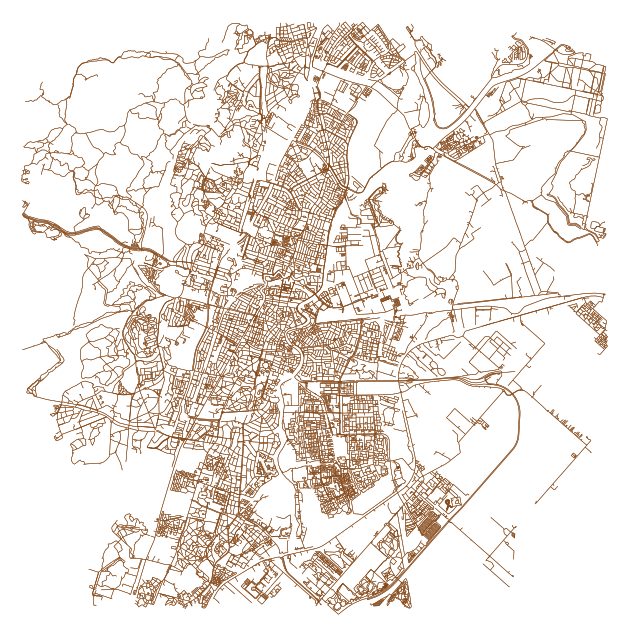

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
center_point_haarlem = (centroid_haarlem.y, centroid_haarlem.x)
radius = 6000 #6 km
G = ox.graph_from_point(center_point_haarlem,
                        dist=radius,
                        network_type='walk',
                        simplify=True)
ox.plot_graph(G, node_size=0,
                edge_color="#864919",
                edge_linewidth=0.35,
                bgcolor='white')

In [17]:
# calculate distance matrix using OSM and Djikstra's algorithm
filtered_n_gdf['nearest_node'] = ox.distance\
    .nearest_nodes(G, 
                   filtered_n_gdf.lng, 
                   filtered_n_gdf.lat)
node_ids = filtered_n_gdf['nearest_node'].to_list()
n = len(node_ids)
dist_matrix = np.zeros((n, n))
for i, src in enumerate(node_ids):
    lengths = nx.single_source_dijkstra_path_length(G,
                                                    src,weight='length')
    for j, tgt in enumerate(node_ids):
        if tgt in lengths:
            dist_matrix[i, j] = lengths.get(tgt, np.inf)

# calculcate time matrix
walking_speed_m_per_min = 80  # average walking speed in meters per minute
time_matrix = dist_matrix / walking_speed_m_per_min
time_matrix = np.ceil(time_matrix).astype(int)

In [20]:
time_matrix

array([[ 0,  5, 11, ..., 27,  3, 16],
       [ 5,  0,  9, ..., 29,  3, 14],
       [11,  9,  0, ..., 35, 10,  6],
       ...,
       [27, 29, 35, ...,  0, 28, 40],
       [ 3,  3, 10, ..., 28,  0, 14],
       [16, 14,  6, ..., 40, 14,  0]])

In [21]:
n = len(time_matrix)

# Create the routing model with parameters: number of locations, 
# number of vehicles / tourists , and depot / start point index
manager = pywrapcp.RoutingIndexManager(n, 1, 0) 
routing = pywrapcp.RoutingModel(manager)


In [24]:
# Define the time callback function
SERVICE_TIME = 7 # 7 minutes service time at each location
def time_callback(from_idx, to_idx):
    from_node = manager.IndexToNode(from_idx)
    to_node = manager.IndexToNode(to_idx)
    total_time = time_matrix[from_node][to_node] \
          + (SERVICE_TIME if from_node != to_node else 0)  # Add service time to the travel time
    return total_time

In [25]:
# Register the transit callback
max_total_time = 60 * 3 # 3 hours in minutes
transit_callback_index = routing.RegisterTransitCallback(time_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
routing.AddDimension(
    transit_callback_index,
    0,
    max_total_time,
    True,
    'Time'
)

True

In [26]:
# Allow fo skipping locaitons where different locaitons have different 
# penalties depending on popularity
min_penalty = 1000
max_penalty = 100000
ratings = filtered_n_gdf['rating']
penalties = np.interp(ratings, (ratings.min(), 
                                ratings.max()), 
                                (min_penalty, max_penalty))

for node in range(1,len(filtered_n_gdf)):
    index = manager.NodeToIndex(node)
    penalthy = int(penalties[node])
    routing.AddDisjunction([index],penalthy)


In [27]:
# Set the search parameters
search_params = pywrapcp.DefaultRoutingSearchParameters()
# Automatically select the first solution strategy
search_params.first_solution_strategy = routing_enums_pb2\
    .FirstSolutionStrategy.AUTOMATIC 
# Use guided local search for optimization
# generally the most efficient metaheuristic for solving routing problems
search_params.local_search_metaheuristic = routing_enums_pb2\
    .LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH 
# Set a time limit for the search
search_params.time_limit.seconds = 30  
 # Limit the number of solutions to explore
search_params.solution_limit = 1000 

In [28]:
solution = routing.SolveWithParameters(search_params)

In [32]:
route = []
index = routing.Start(0)
while not routing.IsEnd(index):
    node = manager.IndexToNode(index)
    route.append(node)
    index = solution.Value(routing.NextVar(index))
route.append(manager.IndexToNode(index))
display(route)

[0, 53, 60, 52, 36, 9, 51, 35, 17, 2, 22, 54, 4, 25, 11, 28, 39, 1, 49, 0]

In [33]:
# Center the map on the first point
start_point = filtered_n_gdf.loc[route[0], 'geometry']
map_ = folium.Map(location=[start_point.x, start_point.y], zoom_start=16,tiles='OpenStreetMap')

# Plot each POI in the route
for i, idx in enumerate(route):
    point = filtered_n_gdf.loc[idx, 'geometry']
    popup_text = f"{i+1}. {filtered_n_gdf.loc[idx, 'name']}" if 'name' in filtered_n_gdf.columns else f"Stop {i+1}"
    folium.CircleMarker(
        location=[point.x, point.y],
        popup=popup_text,
        fill_color='red',
        radius=7,
        fill_opacity=0.7,
        weight=0.1,
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map_)

# Add lines connecting the POIs in route order
route_coords = [(filtered_n_gdf.loc[idx, 'geometry'].x, filtered_n_gdf.loc[idx, 'geometry'].y) for idx in route]
folium.PolyLine(route_coords, color='red', weight=3, opacity=0.8).add_to(map_)

# Show POIs that were filtered but not visited.
visited_set = set(route)
for idx, row in filtered_n_gdf.iterrows():
    if idx not in visited_set:
        folium.CircleMarker(
            location=[row.geometry.x, row.geometry.y],
            color='blue',
            fill=True,
            radius=3,
            fill_opacity=0.7,
            weight=0.1,
            popup=row['name'] if 'name' in row else str(idx)
        ).add_to(map_)

# Show the map
map_